# Exogenous model input from a file
In this notebook we'll demonstrate using an external data source to feed values into a model. We'll use the carbon emissions dataset, and feed total emissions into a stock of excess atmospheric carbon:

<img src="../../models/Climate/Atmospheric_Bathtub.png" alt="Stock and Flow diagram of Carbon Bathtub Model" style="width: 400px;"/>


We'll begin as usual by importing PySD and the machinery we need in order to deal with data manipulation and plotting.

In [1]:
%pylab inline
import pysd
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/Users/houghton/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


We use [Pandas]() library to import emissions data from a `.csv` file. In this command, we both rename the columns of the dataset, and set the index to the 'Year' column.

In [2]:
emissions = pd.read_csv('../../data/Climate/global_emissions.csv', 
                        skiprows=2, index_col='Year',
                        names=['Year', 'Total Emissions', 
                               'Gas Emissions', 'Liquid Emissions', 
                               'Solid Emissions', 'Cement Emissions', 
                               'Flare Emissions', 'Per Capita Emissions'])
emissions.head()

,Total Emissions,Gas Emissions,Liquid Emissions,Solid Emissions,Cement Emissions,Flare Emissions,Per Capita Emissions
Year,,,,,,,
1751,3,0,0,3,0,0,NaN
1752,3,0,0,3,0,0,NaN
1753,3,0,0,3,0,0,NaN
1754,3,0,0,3,0,0,NaN
1755,3,0,0,3,0,0,NaN


In [3]:
model = pysd.read_vensim('../../models/Climate/Atmospheric_Bathtub.mdl')

In our vensim model file, the value of the  inflow to the carbon bathtub, the `Emissions` parameter, is set to zero. We want to instead have this track our exogenous data.
```python
Emissions=
	0

Excess Atmospheric Carbon= INTEG (
	Emissions - Natural Removal,
	0)

Natural Removal=
	Excess Atmospheric Carbon * Removal Constant

Removal Constant=
	0.01
```

### Aligning the model time bounds with that of the dataset
Before we can substitute in our exogenous data, however, we need to ensure that the model will execute over the proper timeseries. The initial and final times of the simulation are specified in the model file as:

In [4]:
print('initial:', model.components.initial_time()) 
print('final:', model.components.final_time())

initial: 0
final: 100


However, the time frame of the dataset runs:

In [5]:
print('initial:', emissions.index[0])
print('final:', emissions.index[-1])

initial: 1751
final: 2011


In order to run the model over a time series equal to that of the data set, we need to specify the appropriate initial conditions, and ask the run function to return to us timestamps equal to that of our dataset:

In [6]:
res = model.run(initial_condition=(emissions.index[0], 
                                   {'Excess Atmospheric Carbon': 0}),
                return_timestamps=emissions.index.values,
                return_columns=['Emissions', 'Excess Atmospheric Carbon'])
res.head()

,Emissions,Excess Atmospheric Carbon
1751,0,0.0
1752,0,0.0
1753,0,0.0
1754,0,0.0
1755,0,0.0


### Pass in our timeseries data
In place of the constant value of `emissions`, we want to substitute our dataset. We can do this in a very straightforward way by passing the Pandas `Series` corresponding to the dataset in a dictionary to the `params` argument of the run function.

In [7]:
res = model.run(initial_condition=(emissions.index[0], 
                                   {'Excess Atmospheric Carbon': 0}),
                return_timestamps=emissions.index.values,
                return_columns=['Emissions', 'Excess Atmospheric Carbon'],
                params={'Emissions': emissions['Total Emissions']})

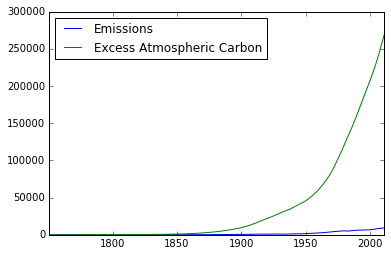

In [8]:
res.plot();